# Regression with a Crab Age Dataset
---
## by Diego Garrocho

Playground Prediction Competition

Playground Series - Season 3, Episode 16


The dataset for this competition (both train and test) was generated from a deep learning model trained on the Crab Age Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

C:\Users\logan\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\logan\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\logan\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
train = pd.read_csv(r'C:\Users\logan\Desktop\Regression Crab\train.csv')
test = pd.read_csv(r'C:\Users\logan\Desktop\Regression Crab\test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [4]:
train.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [5]:
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [6]:
train['Sex'].unique()

array(['I', 'M', 'F'], dtype=object)

In [3]:
# Dropping id as always
train_noid = train.drop('id',axis=1)

In [4]:
# Encoding categorical feature 'Sex'
encoder = LabelEncoder()
train_noid['Sex_encoded'] = encoder.fit_transform(train_noid['Sex'])


In [5]:
# Dropping original column
train_ready = train_noid.drop('Sex',axis=1)

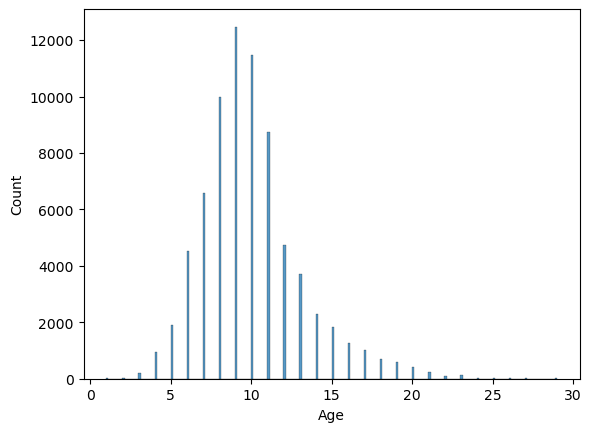

In [10]:
sns.histplot(train_ready['Age'])
plt.show()

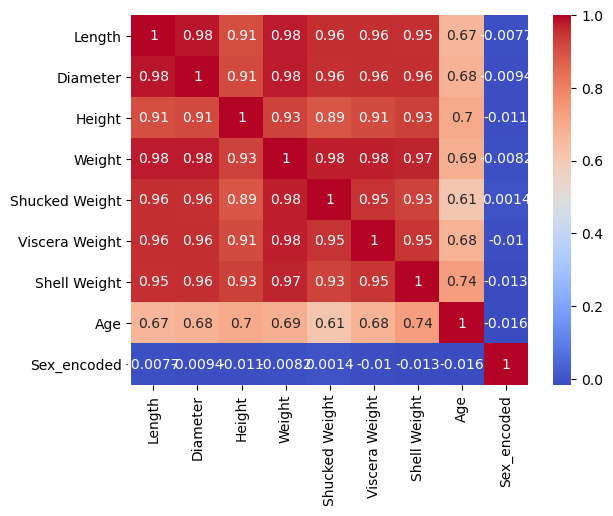

In [32]:
correlation_matrix = train_ready.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

After prepping the data and checking correlations, its clear that there is a strong correlation between all but the target feature which indicates a significant degree of multicollinearity which is not ideal for a regression model. Feature selection or PCA should help with this, given the current number of features PCA would fit better for this particular case.

In [6]:
# Scaling features first then PCA
scaler = StandardScaler()
train_ready_scaled = scaler.fit_transform(train_ready)

pca = PCA()
train_ready_pca = pca.fit_transform(train_ready_scaled)

# Trying something
explained_variance_ratio = pca.explained_variance_ratio_
components = pca.components_

In [7]:
variance_df = pd.DataFrame({'Feature': train_ready.columns, 'Variance': pca.explained_variance_ratio_})
variance_df = variance_df.sort_values(by='Variance', ascending=False)

print(variance_df)
#print(components)

          Feature  Variance
0          Length  0.776147
1        Diameter  0.111150
2          Height  0.067520
3          Weight  0.018747
4  Shucked Weight  0.011470
5  Viscera Weight  0.007013
6    Shell Weight  0.005751
7             Age  0.001153
8     Sex_encoded  0.001050


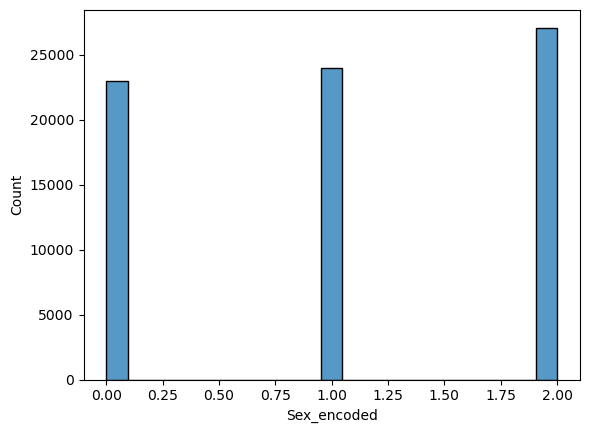

In [14]:
sns.histplot(train_ready['Sex_encoded'])
plt.show()

After the variance analysis, features with a variance lower than 0.01 should be dropped

In [8]:
# Dropping things 
train_slim = train_ready.drop(['Viscera Weight','Shell Weight','Sex_encoded'], axis=1)

## Model setup
---
Setting up an ensemble made of xgboost, catboost, and lgbm using optuna and stratifiedKfold to train.

In [16]:
# Starting with xgboost
X = train_slim.drop('Age', axis=1)
y = train_slim['Age']

def objective1(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'verbosity': 0,
        'eta': trial.suggest_float('eta', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0),
        
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    rmses = []
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dval, 'validation')], early_stopping_rounds=50, verbose_eval=False)
        y_pred = model.predict(dval)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)



In [17]:
study_x = optuna.create_study(direction='minimize')
study_x.optimize(objective1, n_trials=100)

[I 2023-06-06 12:01:41,723] A new study created in memory with name: no-name-0995ef80-ac53-472e-b7dc-363efd5cc514
[I 2023-06-06 12:01:55,079] Trial 0 finished with value: 2.123023333034666 and parameters: {'eta': 0.1433157530049118, 'max_depth': 8, 'subsample': 0.9091278926757792, 'colsample_bytree': 0.6915067758477139, 'alpha': 9.988200373475603, 'lambda': 8.055535296392927, 'min_child_weight': 6.058171931873472}. Best is trial 0 with value: 2.123023333034666.
[I 2023-06-06 12:02:54,373] Trial 1 finished with value: 2.2263700529978343 and parameters: {'eta': 0.3146906514219361, 'max_depth': 7, 'subsample': 0.6020079029641725, 'colsample_bytree': 0.3187756813592729, 'alpha': 1.6805981784582311, 'lambda': 1.406652611651665, 'min_child_weight': 6.5178779979641925}. Best is trial 0 with value: 2.123023333034666.
[I 2023-06-06 12:04:20,148] Trial 2 finished with value: 2.2149878868060773 and parameters: {'eta': 0.23812411661505492, 'max_depth': 8, 'subsample': 0.7625457232378805, 'colsampl

[I 2023-06-06 12:14:07,467] Trial 22 finished with value: 2.1230793359361577 and parameters: {'eta': 0.12815044354760094, 'max_depth': 4, 'subsample': 0.5177691635892867, 'colsample_bytree': 0.9129157875592491, 'alpha': 5.923621282274146, 'lambda': 3.2444074176540285, 'min_child_weight': 5.741634185327174}. Best is trial 12 with value: 2.1174884230833633.
[I 2023-06-06 12:14:53,255] Trial 23 finished with value: 2.1190377812363748 and parameters: {'eta': 0.05341723257824979, 'max_depth': 3, 'subsample': 0.6195125014277916, 'colsample_bytree': 0.821230578774628, 'alpha': 5.044293699809342, 'lambda': 4.670587329677015, 'min_child_weight': 8.614954918933247}. Best is trial 12 with value: 2.1174884230833633.
[I 2023-06-06 12:15:44,389] Trial 24 finished with value: 2.119194602364451 and parameters: {'eta': 0.04870349710866838, 'max_depth': 3, 'subsample': 0.5933872673287394, 'colsample_bytree': 0.8336677522301903, 'alpha': 6.850719075379859, 'lambda': 5.684056895868887, 'min_child_weight':

[I 2023-06-06 12:30:15,097] Trial 45 finished with value: 2.1519172361757652 and parameters: {'eta': 0.0036975499363648204, 'max_depth': 6, 'subsample': 0.8094911751768135, 'colsample_bytree': 0.9568949134158578, 'alpha': 8.801636474667845, 'lambda': 6.394111418737837, 'min_child_weight': 9.110986756502706}. Best is trial 33 with value: 2.1172235947152265.
[I 2023-06-06 12:31:30,092] Trial 46 finished with value: 2.11651730195302 and parameters: {'eta': 0.018791385762274643, 'max_depth': 5, 'subsample': 0.7496397371838788, 'colsample_bytree': 0.9534485839493808, 'alpha': 8.614943221791721, 'lambda': 5.12127660835345, 'min_child_weight': 9.496085754006515}. Best is trial 46 with value: 2.11651730195302.
[I 2023-06-06 12:32:40,030] Trial 47 finished with value: 2.116114951203142 and parameters: {'eta': 0.02235103589284825, 'max_depth': 5, 'subsample': 0.8560921366005972, 'colsample_bytree': 0.9586234813072083, 'alpha': 8.56399328133009, 'lambda': 6.99983321552335, 'min_child_weight': 9.5

[I 2023-06-06 12:49:32,486] Trial 68 finished with value: 2.12086851747408 and parameters: {'eta': 0.08929262281492382, 'max_depth': 8, 'subsample': 0.6834991777964674, 'colsample_bytree': 0.9776331631574237, 'alpha': 9.636283250061746, 'lambda': 6.595963117613066, 'min_child_weight': 8.753220729578086}. Best is trial 65 with value: 2.1152979417562596.
[I 2023-06-06 12:49:59,459] Trial 69 finished with value: 2.1188548262526647 and parameters: {'eta': 0.06121763369684238, 'max_depth': 9, 'subsample': 0.8221291627218514, 'colsample_bytree': 0.9035490777901973, 'alpha': 9.053528151367225, 'lambda': 6.8529786673029, 'min_child_weight': 9.221156349709155}. Best is trial 65 with value: 2.1152979417562596.
[I 2023-06-06 12:50:22,240] Trial 70 finished with value: 2.119861577797187 and parameters: {'eta': 0.0755903146160514, 'max_depth': 8, 'subsample': 0.7617300518862846, 'colsample_bytree': 0.9311225163542668, 'alpha': 9.374554131578671, 'lambda': 7.317038662110422, 'min_child_weight': 8.37

[I 2023-06-06 13:21:50,445] Trial 91 finished with value: 2.115124042235112 and parameters: {'eta': 0.01349824055896764, 'max_depth': 8, 'subsample': 0.6542474956450922, 'colsample_bytree': 0.8069531070166486, 'alpha': 8.96817485905369, 'lambda': 6.378018303527999, 'min_child_weight': 8.793844794632228}. Best is trial 74 with value: 2.1149884389692626.
[I 2023-06-06 13:22:22,004] Trial 92 finished with value: 2.116628516152929 and parameters: {'eta': 0.03909610806902924, 'max_depth': 8, 'subsample': 0.6585348730217975, 'colsample_bytree': 0.8034070459612173, 'alpha': 8.69349128279061, 'lambda': 6.395953724612102, 'min_child_weight': 8.765447117950405}. Best is trial 74 with value: 2.1149884389692626.
[I 2023-06-06 13:24:00,080] Trial 93 finished with value: 2.1182851392370123 and parameters: {'eta': 0.015309879019532539, 'max_depth': 8, 'subsample': 0.7006726885124733, 'colsample_bytree': 0.7134009650924538, 'alpha': 8.983041315827801, 'lambda': 6.783682773670914, 'min_child_weight': 8

In [18]:
best_trial_x = study_x.best_trial
print('Best RMSE for XGBoost:', best_trial_x.value)
print('Best Parameters for XGBoost:', best_trial_x.params)

Best RMSE for XGBoost: 2.1149884389692626
Best Parameters for XGBoost: {'eta': 0.012584470106066427, 'max_depth': 8, 'subsample': 0.6745162357081256, 'colsample_bytree': 0.8750932779964464, 'alpha': 8.933382767225531, 'lambda': 7.376134436465597, 'min_child_weight': 9.20129186942273}


In [19]:
# Now Catboost
def objective2(trial):
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'random_seed': 42,
        'logging_level': 'Silent',
        #'task_type': 'GPU'
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    rmses = []
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_pool = cb.Pool(X_train, y_train)
        val_pool = cb.Pool(X_val, y_val)

        model = cb.CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
        y_pred = model.predict(val_pool)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)


In [20]:
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective2, n_trials=100)

[I 2023-06-06 13:30:19,267] A new study created in memory with name: no-name-daabafb7-2e5d-4f5b-b723-45ddc0107a68
[I 2023-06-06 13:30:26,817] Trial 0 finished with value: 2.1250949295553525 and parameters: {'learning_rate': 0.4363363447592942, 'depth': 5, 'subsample': 0.5392746358641183, 'colsample_bylevel': 0.992486267821393, 'reg_lambda': 9.98934775023392}. Best is trial 0 with value: 2.1250949295553525.
[I 2023-06-06 13:30:37,581] Trial 1 finished with value: 2.126313830798639 and parameters: {'learning_rate': 0.3755855720453994, 'depth': 6, 'subsample': 0.45224477225253745, 'colsample_bylevel': 0.49389072331848916, 'reg_lambda': 4.686052061978491}. Best is trial 0 with value: 2.1250949295553525.
[I 2023-06-06 13:30:53,481] Trial 2 finished with value: 2.1371355704272688 and parameters: {'learning_rate': 0.29429356796927, 'depth': 7, 'subsample': 0.27396461746431955, 'colsample_bylevel': 0.10486538082558716, 'reg_lambda': 3.3052284677410904}. Best is trial 0 with value: 2.1250949295

[I 2023-06-06 13:42:34,569] Trial 26 finished with value: 2.1198326047962377 and parameters: {'learning_rate': 0.05072328766850583, 'depth': 4, 'subsample': 0.9926275744029716, 'colsample_bylevel': 0.8136598382503656, 'reg_lambda': 8.427086098271488}. Best is trial 20 with value: 2.117395139498078.
[I 2023-06-06 13:43:17,057] Trial 27 finished with value: 2.1196282744575172 and parameters: {'learning_rate': 0.09380068505407685, 'depth': 9, 'subsample': 0.8249347679867612, 'colsample_bylevel': 0.6647138230368157, 'reg_lambda': 8.710892801877307}. Best is trial 20 with value: 2.117395139498078.
[I 2023-06-06 13:43:59,810] Trial 28 finished with value: 2.120183536546985 and parameters: {'learning_rate': 0.040048976311930475, 'depth': 5, 'subsample': 0.6553135833667122, 'colsample_bylevel': 0.5686106251528793, 'reg_lambda': 9.42469184415383}. Best is trial 20 with value: 2.117395139498078.
[I 2023-06-06 13:44:29,894] Trial 29 finished with value: 2.1177141789119824 and parameters: {'learni

[I 2023-06-06 13:58:16,996] Trial 53 finished with value: 2.129267121134343 and parameters: {'learning_rate': 0.01235296703014458, 'depth': 8, 'subsample': 0.6742285046964508, 'colsample_bylevel': 0.6507649406150687, 'reg_lambda': 7.911280942335568}. Best is trial 49 with value: 2.1172909131665856.
[I 2023-06-06 13:59:20,307] Trial 54 finished with value: 2.11840157862989 and parameters: {'learning_rate': 0.033059889521724194, 'depth': 8, 'subsample': 0.5663463259480862, 'colsample_bylevel': 0.5817403056758051, 'reg_lambda': 8.709997612692812}. Best is trial 49 with value: 2.1172909131665856.
[I 2023-06-06 14:00:21,374] Trial 55 finished with value: 2.1190558673861415 and parameters: {'learning_rate': 0.061003541381827585, 'depth': 9, 'subsample': 0.8009281026967744, 'colsample_bylevel': 0.6962727937142771, 'reg_lambda': 9.504988658174467}. Best is trial 49 with value: 2.1172909131665856.
[I 2023-06-06 14:00:48,218] Trial 56 finished with value: 2.119950424682046 and parameters: {'lear

[I 2023-06-06 14:16:14,937] Trial 80 finished with value: 2.118761841129024 and parameters: {'learning_rate': 0.13890217058499613, 'depth': 5, 'subsample': 0.5889659223411392, 'colsample_bylevel': 0.6239175811821018, 'reg_lambda': 8.949579010030217}. Best is trial 49 with value: 2.1172909131665856.
[I 2023-06-06 14:16:54,475] Trial 81 finished with value: 2.1179648641791453 and parameters: {'learning_rate': 0.08320002305583657, 'depth': 6, 'subsample': 0.6608420303835881, 'colsample_bylevel': 0.6650895209680422, 'reg_lambda': 9.735440563251668}. Best is trial 49 with value: 2.1172909131665856.
[I 2023-06-06 14:17:38,514] Trial 82 finished with value: 2.1175409667653566 and parameters: {'learning_rate': 0.08019724802486591, 'depth': 5, 'subsample': 0.6281976956968195, 'colsample_bylevel': 0.6104731452249615, 'reg_lambda': 9.244712962856994}. Best is trial 49 with value: 2.1172909131665856.
[I 2023-06-06 14:18:13,572] Trial 83 finished with value: 2.1188080021234206 and parameters: {'lea

In [21]:
best_trial_cat = study_cat.best_trial
print('Best RMSE for cat:', best_trial_cat.value)
print('Best Parameters for cat:', best_trial_cat.params)

Best RMSE for cat: 2.1172348861397836
Best Parameters for cat: {'learning_rate': 0.06516604898374986, 'depth': 5, 'subsample': 0.7426816682920059, 'colsample_bylevel': 0.6842626842770562, 'reg_lambda': 9.795159835271281}


In [22]:
# Now LGBM
def objective3(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'random_state': 42,
        'verbosity': -1,
        'device':'gpu'
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    rmses = []
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, val_data], early_stopping_rounds=50, verbose_eval=False)
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)


In [23]:
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective3, n_trials=100)

[I 2023-06-06 14:29:49,718] A new study created in memory with name: no-name-774fdc57-8194-4d8a-a492-31a775cbb960
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is depr

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-06 14:34:39,322] Trial 9 finished with value: 2.119225860470013 and parameters: {'learning_rate': 0.07581512299331898, 'max_depth': 7, 'subsample': 0.7328073383794247, 'colsample_bytree': 0.77475802159204, 'reg_lambda': 2.5452682977175978}. 

[I 2023-06-06 14:34:44,696] Trial 10 finished with value: 2.1367427197897984 and parameters: {'learning_rate': 0.48601467493083284, 'max_depth': 10, 'subsample': 0.8398641177251719, 'colsample_bytree': 0.9828025055190083, 'reg_lambda': 1.9628673495861928}. Best is trial 9 with value: 2.119225860470013.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-06 14:38:35,360] Trial 20 finished with value: 2.1234316687468713 and parameters: {'learning_rate': 0.13532103495371162, 'max_depth': 8, 'subsample': 0.9468080774191756, 'colsample_bytree': 0.9113177505480397, 'reg_lambda': 1.840107380587853

[I 2023-06-06 14:39:38,487] Trial 21 finished with value: 2.1206363807652133 and parameters: {'learning_rate': 0.010402054779413078, 'max_depth': 9, 'subsample': 0.1588973018404563, 'colsample_bytree': 0.8325122065554558, 'reg_lambda': 3.4426131275049494}. Best is trial 9 with value: 2.119225860470013.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-06 14:42:28,382] Trial 31 finished with value: 2.1194861503990112 and parameters: {'learning_rate': 0.04650064960741081, 'max_depth': 8, 'subsample': 0.5296793855073736, 'colsample_bytree': 0.811972453535903, 'reg_lambda': 5.844818107550751}

[I 2023-06-06 14:42:44,438] Trial 32 finished with value: 2.1197627178256444 and parameters: {'learning_rate': 0.06840053665807488, 'max_depth': 8, 'subsample': 0.5472726333418634, 'colsample_bytree': 0.744112562661671, 'reg_lambda': 6.001872833472011}. Best is trial 30 with value: 2.1186163384861554.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and 

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-06 14:45:15,790] Trial 42 finished with value: 2.119434677511321 and parameters: {'learning_rate': 0.08269395030776948, 'max_depth': 5, 'subsample': 0.5757317389119493, 'colsample_bytree': 0.8047465335631935, 'reg_lambda': 6.3099678877047705

[I 2023-06-06 14:45:37,023] Trial 43 finished with value: 2.121576653044682 and parameters: {'learning_rate': 0.036474318840911034, 'max_depth': 6, 'subsample': 0.579402527179744, 'colsample_bytree': 0.9264885293993287, 'reg_lambda': 7.675233734483528}. Best is trial 30 with value: 2.1186163384861554.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and 

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-06 14:48:48,227] Trial 53 finished with value: 2.121557209270676 and parameters: {'learning_rate': 0.017416823245776234, 'max_depth': 4, 'subsample': 0.6664402696795898, 'colsample_bytree': 0.8384265365459711, 'reg_lambda': 5.778072292422919

[I 2023-06-06 14:49:01,861] Trial 54 finished with value: 2.1212514615336273 and parameters: {'learning_rate': 0.06776481254329281, 'max_depth': 5, 'subsample': 0.6305146789831112, 'colsample_bytree': 0.9428790217821407, 'reg_lambda': 8.10618120567367}. Best is trial 45 with value: 2.118010820419926.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and w

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-06 14:52:10,165] Trial 64 finished with value: 2.118709835715952 and parameters: {'learning_rate': 0.05173524167283522, 'max_depth': 5, 'subsample': 0.6059752774010942, 'colsample_bytree': 0.7418566047150972, 'reg_lambda': 8.915902574704816}

[I 2023-06-06 14:52:21,813] Trial 65 finished with value: 2.1213805458307036 and parameters: {'learning_rate': 0.07121158205020746, 'max_depth': 5, 'subsample': 0.541121329993978, 'colsample_bytree': 0.9156429100806971, 'reg_lambda': 9.990588875688829}. Best is trial 45 with value: 2.118010820419926.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and w

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-06 14:54:47,128] Trial 75 finished with value: 2.119730411997818 and parameters: {'learning_rate': 0.04320741592258737, 'max_depth': 4, 'subsample': 0.6275433255458863, 'colsample_bytree': 0.9013174818847682, 'reg_lambda': 8.026845030181676}

[I 2023-06-06 14:54:55,986] Trial 76 finished with value: 2.11985348463825 and parameters: {'learning_rate': 0.10582212912686662, 'max_depth': 4, 'subsample': 0.6048845044445326, 'colsample_bytree': 0.9600595087430037, 'reg_lambda': 8.654690237376602}. Best is trial 73 with value: 2.117875295258975.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and wi

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-06 14:57:29,373] Trial 86 finished with value: 2.1180888873377506 and parameters: {'learning_rate': 0.06332990871592903, 'max_depth': 4, 'subsample': 0.7330641481998608, 'colsample_bytree': 0.7193393849740708, 'reg_lambda': 7.867202588284746

[I 2023-06-06 14:57:44,610] Trial 87 finished with value: 2.1184646737798776 and parameters: {'learning_rate': 0.05913261164953811, 'max_depth': 4, 'subsample': 0.7237717178370853, 'colsample_bytree': 0.7088185791055135, 'reg_lambda': 8.004258767854402}. Best is trial 73 with value: 2.117875295258975.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and 

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argum

C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-06-06 15:00:58,177] Trial 97 finished with value: 2.118262827537539 and parameters: {'learning_rate': 0.08781564659171515, 'max_depth': 4, 'subsample': 0.6893230720889468, 'colsample_bytree': 0.7298667603898922, 'reg_lambda': 7.151323226334214}

[I 2023-06-06 15:01:12,160] Trial 98 finished with value: 2.1200836845048183 and parameters: {'learning_rate': 0.08415727931588952, 'max_depth': 4, 'subsample': 0.6413541458095153, 'colsample_bytree': 0.6921370308082354, 'reg_lambda': 7.021805543232543}. Best is trial 73 with value: 2.117875295258975.
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\logan\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and 

In [24]:
best_trial_lgb = study_lgb.best_trial
print('Best RMSE for LGBM:', best_trial_lgb.value)
print('Best Parameters for LGBM:', best_trial_lgb.params)

Best RMSE for LGBM: 2.117875295258975
Best Parameters for LGBM: {'learning_rate': 0.08320334500042223, 'max_depth': 4, 'subsample': 0.6315078724387855, 'colsample_bytree': 0.897540284846267, 'reg_lambda': 8.19322346200202}


In [28]:
best_xgb = xgb.XGBRegressor(**best_trial_x.params)
best_cat = cb.CatBoostRegressor(**best_trial_cat.params)
best_lgbm = lgb.LGBMRegressor(**best_trial_lgb.params)

In [29]:
# Fitting models 
best_xgb.fit(X, y)
best_lgbm.fit(X, y)
best_cat.fit(X, y)

0:	learn: 3.0945294	total: 5.89ms	remaining: 5.89s
1:	learn: 3.0202023	total: 11.3ms	remaining: 5.65s
2:	learn: 2.9549678	total: 16.6ms	remaining: 5.53s
3:	learn: 2.8952618	total: 22ms	remaining: 5.47s
4:	learn: 2.8413203	total: 27.1ms	remaining: 5.39s
5:	learn: 2.7927099	total: 32.2ms	remaining: 5.33s
6:	learn: 2.7502285	total: 37.8ms	remaining: 5.36s
7:	learn: 2.7083747	total: 43.5ms	remaining: 5.39s
8:	learn: 2.6742182	total: 48.4ms	remaining: 5.32s
9:	learn: 2.6425054	total: 53.8ms	remaining: 5.32s
10:	learn: 2.6111369	total: 59.2ms	remaining: 5.32s
11:	learn: 2.5849297	total: 64.5ms	remaining: 5.31s
12:	learn: 2.5565318	total: 69.7ms	remaining: 5.29s
13:	learn: 2.5339930	total: 74.5ms	remaining: 5.25s
14:	learn: 2.5146387	total: 79.8ms	remaining: 5.24s
15:	learn: 2.4939578	total: 85.1ms	remaining: 5.23s
16:	learn: 2.4797044	total: 89.6ms	remaining: 5.18s
17:	learn: 2.4650226	total: 94.4ms	remaining: 5.15s
18:	learn: 2.4515501	total: 99.4ms	remaining: 5.13s
19:	learn: 2.4394754	tot

187:	learn: 2.1320118	total: 860ms	remaining: 3.71s
188:	learn: 2.1316468	total: 866ms	remaining: 3.71s
189:	learn: 2.1314149	total: 870ms	remaining: 3.71s
190:	learn: 2.1311013	total: 875ms	remaining: 3.7s
191:	learn: 2.1308842	total: 878ms	remaining: 3.7s
192:	learn: 2.1302510	total: 883ms	remaining: 3.69s
193:	learn: 2.1300189	total: 889ms	remaining: 3.69s
194:	learn: 2.1300083	total: 894ms	remaining: 3.69s
195:	learn: 2.1299016	total: 898ms	remaining: 3.69s
196:	learn: 2.1297141	total: 902ms	remaining: 3.68s
197:	learn: 2.1296389	total: 907ms	remaining: 3.67s
198:	learn: 2.1295264	total: 912ms	remaining: 3.67s
199:	learn: 2.1292394	total: 916ms	remaining: 3.66s
200:	learn: 2.1292291	total: 921ms	remaining: 3.66s
201:	learn: 2.1292195	total: 926ms	remaining: 3.66s
202:	learn: 2.1289700	total: 930ms	remaining: 3.65s
203:	learn: 2.1289598	total: 935ms	remaining: 3.65s
204:	learn: 2.1283362	total: 939ms	remaining: 3.64s
205:	learn: 2.1282540	total: 943ms	remaining: 3.63s
206:	learn: 2.

374:	learn: 2.1044397	total: 1.7s	remaining: 2.83s
375:	learn: 2.1043829	total: 1.7s	remaining: 2.83s
376:	learn: 2.1042214	total: 1.71s	remaining: 2.83s
377:	learn: 2.1041949	total: 1.71s	remaining: 2.82s
378:	learn: 2.1041854	total: 1.72s	remaining: 2.82s
379:	learn: 2.1041121	total: 1.72s	remaining: 2.81s
380:	learn: 2.1039773	total: 1.73s	remaining: 2.81s
381:	learn: 2.1039449	total: 1.73s	remaining: 2.8s
382:	learn: 2.1038130	total: 1.74s	remaining: 2.8s
383:	learn: 2.1036934	total: 1.74s	remaining: 2.79s
384:	learn: 2.1035318	total: 1.75s	remaining: 2.79s
385:	learn: 2.1034278	total: 1.75s	remaining: 2.79s
386:	learn: 2.1033194	total: 1.75s	remaining: 2.78s
387:	learn: 2.1033037	total: 1.76s	remaining: 2.78s
388:	learn: 2.1031582	total: 1.76s	remaining: 2.77s
389:	learn: 2.1031513	total: 1.77s	remaining: 2.77s
390:	learn: 2.1031445	total: 1.77s	remaining: 2.76s
391:	learn: 2.1030326	total: 1.78s	remaining: 2.76s
392:	learn: 2.1030048	total: 1.78s	remaining: 2.75s
393:	learn: 2.10

550:	learn: 2.0921377	total: 2.54s	remaining: 2.07s
551:	learn: 2.0921239	total: 2.54s	remaining: 2.06s
552:	learn: 2.0920460	total: 2.55s	remaining: 2.06s
553:	learn: 2.0920080	total: 2.55s	remaining: 2.06s
554:	learn: 2.0919172	total: 2.56s	remaining: 2.05s
555:	learn: 2.0918999	total: 2.56s	remaining: 2.05s
556:	learn: 2.0918604	total: 2.57s	remaining: 2.04s
557:	learn: 2.0917690	total: 2.57s	remaining: 2.04s
558:	learn: 2.0916928	total: 2.58s	remaining: 2.03s
559:	learn: 2.0916005	total: 2.58s	remaining: 2.03s
560:	learn: 2.0915944	total: 2.59s	remaining: 2.02s
561:	learn: 2.0915929	total: 2.59s	remaining: 2.02s
562:	learn: 2.0914996	total: 2.6s	remaining: 2.02s
563:	learn: 2.0913669	total: 2.6s	remaining: 2.01s
564:	learn: 2.0912971	total: 2.61s	remaining: 2.01s
565:	learn: 2.0912497	total: 2.61s	remaining: 2s
566:	learn: 2.0911265	total: 2.62s	remaining: 2s
567:	learn: 2.0910632	total: 2.62s	remaining: 1.99s
568:	learn: 2.0910301	total: 2.63s	remaining: 1.99s
569:	learn: 2.090942

725:	learn: 2.0827823	total: 3.38s	remaining: 1.27s
726:	learn: 2.0827208	total: 3.38s	remaining: 1.27s
727:	learn: 2.0827127	total: 3.38s	remaining: 1.26s
728:	learn: 2.0827099	total: 3.39s	remaining: 1.26s
729:	learn: 2.0826673	total: 3.4s	remaining: 1.25s
730:	learn: 2.0825824	total: 3.4s	remaining: 1.25s
731:	learn: 2.0825667	total: 3.4s	remaining: 1.25s
732:	learn: 2.0825197	total: 3.41s	remaining: 1.24s
733:	learn: 2.0824874	total: 3.41s	remaining: 1.24s
734:	learn: 2.0824838	total: 3.42s	remaining: 1.23s
735:	learn: 2.0824337	total: 3.42s	remaining: 1.23s
736:	learn: 2.0824195	total: 3.43s	remaining: 1.22s
737:	learn: 2.0823426	total: 3.43s	remaining: 1.22s
738:	learn: 2.0822678	total: 3.44s	remaining: 1.21s
739:	learn: 2.0822089	total: 3.44s	remaining: 1.21s
740:	learn: 2.0821825	total: 3.45s	remaining: 1.21s
741:	learn: 2.0820476	total: 3.45s	remaining: 1.2s
742:	learn: 2.0820208	total: 3.46s	remaining: 1.2s
743:	learn: 2.0820180	total: 3.46s	remaining: 1.19s
744:	learn: 2.081

900:	learn: 2.0756629	total: 4.2s	remaining: 461ms
901:	learn: 2.0755980	total: 4.2s	remaining: 457ms
902:	learn: 2.0755835	total: 4.21s	remaining: 452ms
903:	learn: 2.0755317	total: 4.21s	remaining: 447ms
904:	learn: 2.0755090	total: 4.22s	remaining: 443ms
905:	learn: 2.0754827	total: 4.22s	remaining: 438ms
906:	learn: 2.0754662	total: 4.23s	remaining: 433ms
907:	learn: 2.0754120	total: 4.23s	remaining: 429ms
908:	learn: 2.0753318	total: 4.24s	remaining: 424ms
909:	learn: 2.0753265	total: 4.24s	remaining: 419ms
910:	learn: 2.0753078	total: 4.25s	remaining: 415ms
911:	learn: 2.0753033	total: 4.25s	remaining: 410ms
912:	learn: 2.0752956	total: 4.25s	remaining: 406ms
913:	learn: 2.0752494	total: 4.26s	remaining: 401ms
914:	learn: 2.0751877	total: 4.26s	remaining: 396ms
915:	learn: 2.0751583	total: 4.27s	remaining: 391ms
916:	learn: 2.0751096	total: 4.27s	remaining: 387ms
917:	learn: 2.0750862	total: 4.28s	remaining: 382ms
918:	learn: 2.0750314	total: 4.28s	remaining: 378ms
919:	learn: 2.

In [31]:
# Now creating an ensemble with the three using different method


xgb_pred = best_xgb.predict(X)
catboost_pred = best_cat.predict(X)
lgbm_pred = best_lgbm.predict(X)

# Ensemble the predictions
ensemble_pred = (xgb_pred + catboost_pred + lgbm_pred) / 3  # Average the predictions

# Evaluate the ensemble predictions
ensemble_rmse = mean_squared_error(y, ensemble_pred, squared=False)
print('Ensemble RMSE:', ensemble_rmse)

Ensemble RMSE: 2.30666924438985


In [9]:
# Testing set transformation
# Dropping id as always
test_ready = test.drop(['id','Viscera Weight','Shell Weight','Sex'],axis=1)


In [34]:
# actual prediction


xgb_predictions = best_xgb.predict(test_ready)
catboost_predictions = best_cat.predict(test_ready)
lgbm_predictions = best_lgbm.predict(test_ready)

# Ensemble the predictions
ensemble_predictions = (xgb_predictions + catboost_predictions + lgbm_predictions) / 3  # Average the predictions


In [36]:
# Create a new DataFrame with 'id' and 'Class' columns
submission_df = pd.DataFrame({'id': test['id'], 'Age': ensemble_predictions})

# Save the new DataFrame to a CSV file
submission_df.to_csv('submission1.csv', index=False)

In [37]:
# Create a new DataFrame with 'id' and 'Class' columns
submission1_df = pd.DataFrame({'id': test['id'], 'Age': xgb_predictions})

# Save the new DataFrame to a CSV file
submission1_df.to_csv('submission2.csv', index=False)

In [39]:
# Create a new DataFrame with 'id' and 'Class' columns
submission2_df = pd.DataFrame({'id': test['id'], 'Age': catboost_predictions})

# Save the new DataFrame to a CSV file
submission2_df.to_csv('submission3.csv', index=False)

In [40]:
# Create a new DataFrame with 'id' and 'Class' columns
submission3_df = pd.DataFrame({'id': test['id'], 'Age': lgbm_predictions})

# Save the new DataFrame to a CSV file
submission3_df.to_csv('submission4.csv', index=False)

In [41]:
# No xgb ensemble
ensemble1_predictions = (catboost_predictions + lgbm_predictions) / 2  # Average the predictions


In [42]:
# Create a new DataFrame with 'id' and 'Class' columns
submission4_df = pd.DataFrame({'id': test['id'], 'Age': ensemble1_predictions})

# Save the new DataFrame to a CSV file
submission4_df.to_csv('submission5.csv', index=False)

XGBoost performed badly compared to the other 2 and catboost scored the highest on its own, probably trying more feature engineering next on the same models.

## Feature Engineering Round 2

In [10]:
train_feat = train_slim.copy()

# Making 0 in Height into 0.001
train_feat['Height'] = train_feat['Height'].replace(0.0, 0.001)

# Testing simple extra features
train_feat["Volume"] = train_feat["Length"] * train_feat["Diameter"] * train_feat["Height"]
train_feat["LogDensity"] = np.log(train_feat["Weight"] / train_feat["Volume"])

In [44]:
X1 = train_feat.drop('Age', axis=1)
y1 = train_feat['Age']

#Loading into catboost only
best_cat.fit(X1, y1)

0:	learn: 3.0941632	total: 6.4ms	remaining: 6.39s
1:	learn: 3.0208691	total: 12ms	remaining: 6s
2:	learn: 2.9561178	total: 17.2ms	remaining: 5.71s
3:	learn: 2.8976361	total: 21.8ms	remaining: 5.44s
4:	learn: 2.8438469	total: 26.8ms	remaining: 5.34s
5:	learn: 2.7948292	total: 31.5ms	remaining: 5.21s
6:	learn: 2.7497339	total: 36.1ms	remaining: 5.12s
7:	learn: 2.7112463	total: 40.6ms	remaining: 5.04s
8:	learn: 2.6724837	total: 45.7ms	remaining: 5.03s
9:	learn: 2.6398556	total: 50.7ms	remaining: 5.02s
10:	learn: 2.6120615	total: 55.9ms	remaining: 5.02s
11:	learn: 2.5852001	total: 61.2ms	remaining: 5.04s
12:	learn: 2.5585780	total: 65.9ms	remaining: 5s
13:	learn: 2.5347259	total: 71.1ms	remaining: 5s
14:	learn: 2.5132236	total: 75.8ms	remaining: 4.97s
15:	learn: 2.4951440	total: 81.1ms	remaining: 4.99s
16:	learn: 2.4808720	total: 86.1ms	remaining: 4.98s
17:	learn: 2.4645364	total: 91.1ms	remaining: 4.97s
18:	learn: 2.4486591	total: 95.9ms	remaining: 4.95s
19:	learn: 2.4327883	total: 101ms	

183:	learn: 2.1311562	total: 858ms	remaining: 3.8s
184:	learn: 2.1310322	total: 863ms	remaining: 3.8s
185:	learn: 2.1307476	total: 869ms	remaining: 3.8s
186:	learn: 2.1303030	total: 874ms	remaining: 3.8s
187:	learn: 2.1298356	total: 878ms	remaining: 3.79s
188:	learn: 2.1296472	total: 883ms	remaining: 3.79s
189:	learn: 2.1292792	total: 887ms	remaining: 3.78s
190:	learn: 2.1291537	total: 892ms	remaining: 3.78s
191:	learn: 2.1289468	total: 897ms	remaining: 3.77s
192:	learn: 2.1287867	total: 901ms	remaining: 3.77s
193:	learn: 2.1283101	total: 906ms	remaining: 3.76s
194:	learn: 2.1282363	total: 911ms	remaining: 3.76s
195:	learn: 2.1280114	total: 915ms	remaining: 3.75s
196:	learn: 2.1277799	total: 919ms	remaining: 3.75s
197:	learn: 2.1277697	total: 924ms	remaining: 3.74s
198:	learn: 2.1273619	total: 929ms	remaining: 3.74s
199:	learn: 2.1270523	total: 934ms	remaining: 3.73s
200:	learn: 2.1269000	total: 939ms	remaining: 3.73s
201:	learn: 2.1264769	total: 944ms	remaining: 3.73s
202:	learn: 2.12

360:	learn: 2.1048585	total: 1.71s	remaining: 3.03s
361:	learn: 2.1048125	total: 1.72s	remaining: 3.03s
362:	learn: 2.1048078	total: 1.72s	remaining: 3.02s
363:	learn: 2.1046527	total: 1.73s	remaining: 3.02s
364:	learn: 2.1045069	total: 1.73s	remaining: 3.01s
365:	learn: 2.1044991	total: 1.74s	remaining: 3.01s
366:	learn: 2.1043748	total: 1.74s	remaining: 3s
367:	learn: 2.1042870	total: 1.75s	remaining: 3s
368:	learn: 2.1041089	total: 1.75s	remaining: 2.99s
369:	learn: 2.1040442	total: 1.75s	remaining: 2.99s
370:	learn: 2.1038569	total: 1.76s	remaining: 2.98s
371:	learn: 2.1037093	total: 1.76s	remaining: 2.98s
372:	learn: 2.1037031	total: 1.77s	remaining: 2.97s
373:	learn: 2.1037024	total: 1.77s	remaining: 2.97s
374:	learn: 2.1036955	total: 1.78s	remaining: 2.97s
375:	learn: 2.1036612	total: 1.78s	remaining: 2.96s
376:	learn: 2.1036442	total: 1.79s	remaining: 2.96s
377:	learn: 2.1035263	total: 1.79s	remaining: 2.95s
378:	learn: 2.1033859	total: 1.8s	remaining: 2.95s
379:	learn: 2.10327

529:	learn: 2.0935123	total: 2.54s	remaining: 2.25s
530:	learn: 2.0934338	total: 2.54s	remaining: 2.25s
531:	learn: 2.0933268	total: 2.55s	remaining: 2.24s
532:	learn: 2.0932516	total: 2.55s	remaining: 2.24s
533:	learn: 2.0931814	total: 2.56s	remaining: 2.23s
534:	learn: 2.0931548	total: 2.56s	remaining: 2.23s
535:	learn: 2.0931194	total: 2.57s	remaining: 2.22s
536:	learn: 2.0930428	total: 2.57s	remaining: 2.22s
537:	learn: 2.0929713	total: 2.58s	remaining: 2.21s
538:	learn: 2.0929706	total: 2.58s	remaining: 2.21s
539:	learn: 2.0928709	total: 2.59s	remaining: 2.2s
540:	learn: 2.0927995	total: 2.59s	remaining: 2.2s
541:	learn: 2.0927990	total: 2.6s	remaining: 2.19s
542:	learn: 2.0927167	total: 2.6s	remaining: 2.19s
543:	learn: 2.0927117	total: 2.61s	remaining: 2.19s
544:	learn: 2.0926849	total: 2.61s	remaining: 2.18s
545:	learn: 2.0925949	total: 2.62s	remaining: 2.18s
546:	learn: 2.0925074	total: 2.62s	remaining: 2.17s
547:	learn: 2.0924228	total: 2.63s	remaining: 2.17s
548:	learn: 2.09

707:	learn: 2.0838759	total: 3.39s	remaining: 1.4s
708:	learn: 2.0838619	total: 3.4s	remaining: 1.4s
709:	learn: 2.0838435	total: 3.4s	remaining: 1.39s
710:	learn: 2.0837842	total: 3.41s	remaining: 1.39s
711:	learn: 2.0837066	total: 3.41s	remaining: 1.38s
712:	learn: 2.0836300	total: 3.42s	remaining: 1.38s
713:	learn: 2.0835693	total: 3.42s	remaining: 1.37s
714:	learn: 2.0834574	total: 3.43s	remaining: 1.37s
715:	learn: 2.0834127	total: 3.43s	remaining: 1.36s
716:	learn: 2.0833534	total: 3.44s	remaining: 1.36s
717:	learn: 2.0832870	total: 3.44s	remaining: 1.35s
718:	learn: 2.0832023	total: 3.44s	remaining: 1.35s
719:	learn: 2.0831965	total: 3.45s	remaining: 1.34s
720:	learn: 2.0831229	total: 3.46s	remaining: 1.34s
721:	learn: 2.0831206	total: 3.46s	remaining: 1.33s
722:	learn: 2.0830981	total: 3.46s	remaining: 1.33s
723:	learn: 2.0830614	total: 3.47s	remaining: 1.32s
724:	learn: 2.0830582	total: 3.48s	remaining: 1.32s
725:	learn: 2.0829995	total: 3.48s	remaining: 1.31s
726:	learn: 2.08

882:	learn: 2.0760733	total: 4.23s	remaining: 561ms
883:	learn: 2.0760119	total: 4.24s	remaining: 556ms
884:	learn: 2.0759769	total: 4.24s	remaining: 552ms
885:	learn: 2.0758801	total: 4.25s	remaining: 547ms
886:	learn: 2.0758305	total: 4.25s	remaining: 542ms
887:	learn: 2.0757579	total: 4.26s	remaining: 537ms
888:	learn: 2.0757449	total: 4.26s	remaining: 532ms
889:	learn: 2.0756940	total: 4.27s	remaining: 528ms
890:	learn: 2.0756631	total: 4.27s	remaining: 523ms
891:	learn: 2.0755781	total: 4.28s	remaining: 518ms
892:	learn: 2.0755306	total: 4.28s	remaining: 513ms
893:	learn: 2.0754806	total: 4.29s	remaining: 508ms
894:	learn: 2.0754312	total: 4.29s	remaining: 504ms
895:	learn: 2.0753929	total: 4.3s	remaining: 499ms
896:	learn: 2.0753604	total: 4.3s	remaining: 494ms
897:	learn: 2.0753572	total: 4.31s	remaining: 489ms
898:	learn: 2.0753156	total: 4.31s	remaining: 484ms
899:	learn: 2.0752531	total: 4.32s	remaining: 480ms
900:	learn: 2.0751327	total: 4.32s	remaining: 475ms
901:	learn: 2.

In [32]:
# Into the test set too
test_new = test_ready.copy()

# Making 0 in Height into 0.001
test_new['Height'] = test_new['Height'].replace(0.0, 0.001)


test_new["Volume"] = test_new["Length"] * test_new["Diameter"] * test_new["Height"]
test_new["LogDensity"] = np.log(test_new["Weight"] / test_new["Volume"])

In [46]:
catboost_new = best_cat.predict(test_new)

# Create a new DataFrame with 'id' and 'Class' columns
submissionnew_df = pd.DataFrame({'id': test['id'], 'Age': catboost_new})

# Save the new DataFrame to a CSV file
submissionnew_df.to_csv('submission_new.csv', index=False)

## PCA
---
Those features made no impact so now trying with pca too

In [18]:
train_pre = train_feat.drop('Age',axis=1)

In [19]:
# PCA and scaler before
scaler = StandardScaler()
train_pre_scaled = scaler.fit_transform(train_pre)


pca = PCA()
pca.fit(train_pre_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

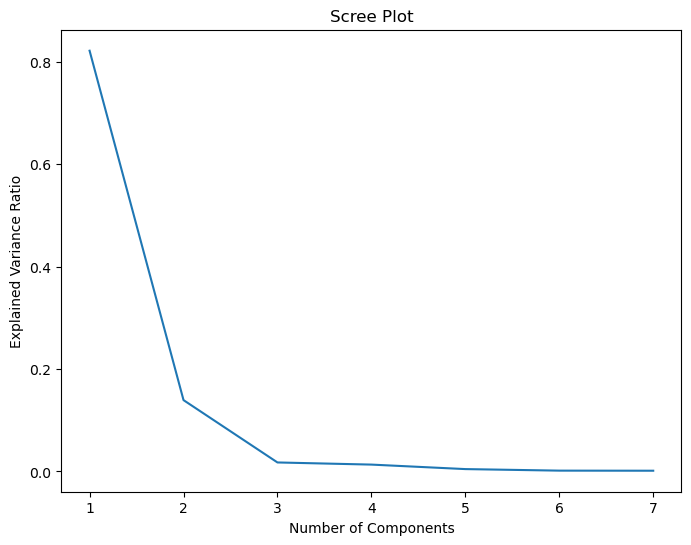

In [20]:
# Plot the scree plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=np.arange(1, len(explained_variance_ratio)+1), y=explained_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()


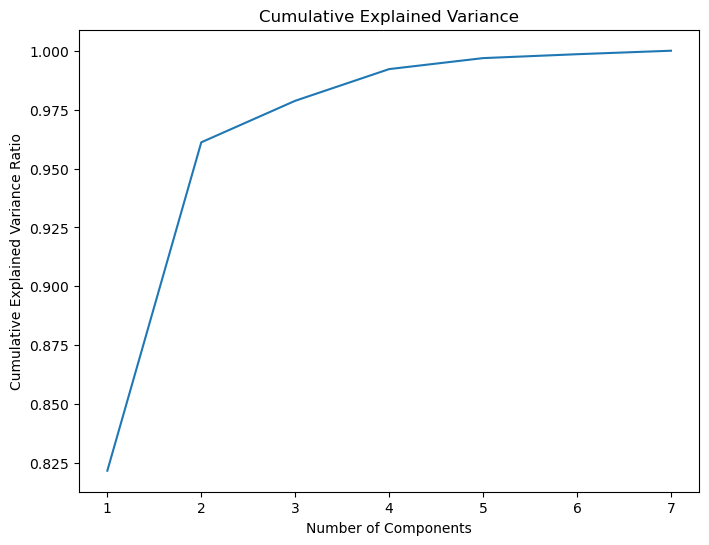

In [21]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
sns.lineplot(x=np.arange(1, len(cumulative_variance_ratio)+1), y=cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.show()

In [22]:
# Perform PCA with the chosen number of components
pca = PCA(n_components=3)
components = pca.fit_transform(train_feat_scaled)

# Create a new DataFrame with the three components
component_names = [f"Component {i+1}" for i in range(3)]
last_df = pd.DataFrame(components, columns=component_names)

# Display the new DataFrame
print(last_df.head())

   Component 1  Component 2  Component 3
0     1.101996     0.063758    -0.621720
1    -2.217577    -0.661537    -0.034497
2     0.471606    -0.119523    -0.442431
3     4.325630     0.404826    -0.894852
4    -0.516875     1.348076    -0.441881


In [23]:
# Add 'Age' column to 'last_df' using pd.concat()
last_df = pd.concat([last_df, train_feat['Age']], axis=1)

In [24]:
X2 = last_df.drop('Age', axis=1)
y2 = last_df['Age']

In [27]:
# Now Catboost
def objective_(trial):
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'random_seed': 42,
        'logging_level': 'Silent',
        #'task_type': 'GPU'
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    rmses = []
    for train_idx, val_idx in kf.split(X2, y2):
        X_train, X_val = X2.iloc[train_idx], X2.iloc[val_idx]
        y_train, y_val = y2.iloc[train_idx], y2.iloc[val_idx]

        train_pool = cb.Pool(X_train, y_train)
        val_pool = cb.Pool(X_val, y_val)

        model = cb.CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
        y_pred = model.predict(val_pool)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)


In [28]:
study_last = optuna.create_study(direction='minimize')
study_last.optimize(objective_, n_trials=100)

[I 2023-06-06 20:13:24,061] A new study created in memory with name: no-name-54189df8-e29d-4a1a-824a-4caa1c45bdb0
[I 2023-06-06 20:13:59,425] Trial 0 finished with value: 0.1597926530507632 and parameters: {'learning_rate': 0.10442725199743602, 'depth': 6, 'subsample': 0.907321348540512, 'colsample_bylevel': 0.48273409159118397, 'reg_lambda': 2.241026710967511}. Best is trial 0 with value: 0.1597926530507632.
[I 2023-06-06 20:14:36,103] Trial 1 finished with value: 0.1544526268360112 and parameters: {'learning_rate': 0.18661820092151227, 'depth': 7, 'subsample': 0.4246851683728261, 'colsample_bylevel': 0.9019343893047944, 'reg_lambda': 9.047514527551714}. Best is trial 1 with value: 0.1544526268360112.
[I 2023-06-06 20:14:54,266] Trial 2 finished with value: 0.15692937227331338 and parameters: {'learning_rate': 0.4240649472385633, 'depth': 5, 'subsample': 0.5027568948810766, 'colsample_bylevel': 0.988442169319539, 'reg_lambda': 7.094168209226042}. Best is trial 1 with value: 0.15445262

[I 2023-06-06 20:38:19,009] Trial 26 finished with value: 0.15306878233679003 and parameters: {'learning_rate': 0.4922763031445353, 'depth': 9, 'subsample': 0.8173552807293623, 'colsample_bylevel': 0.8076874077466069, 'reg_lambda': 4.513878317582532}. Best is trial 19 with value: 0.15049269444179056.
[I 2023-06-06 20:40:31,626] Trial 27 finished with value: 0.1521216819575406 and parameters: {'learning_rate': 0.4099800038764881, 'depth': 10, 'subsample': 0.7595898256183677, 'colsample_bylevel': 0.9121505723685978, 'reg_lambda': 5.089009219281447}. Best is trial 19 with value: 0.15049269444179056.
[I 2023-06-06 20:41:01,001] Trial 28 finished with value: 0.1544886916899399 and parameters: {'learning_rate': 0.46463890775656885, 'depth': 9, 'subsample': 0.855123438143259, 'colsample_bylevel': 0.6009082507593203, 'reg_lambda': 4.344404880882896}. Best is trial 19 with value: 0.15049269444179056.
[I 2023-06-06 20:41:19,611] Trial 29 finished with value: 0.15660945649029132 and parameters: {

[I 2023-06-06 21:14:30,009] Trial 52 finished with value: 0.1514709223040585 and parameters: {'learning_rate': 0.3293828974370371, 'depth': 10, 'subsample': 0.9052151043986116, 'colsample_bylevel': 0.9975514204978626, 'reg_lambda': 4.635074999722136}. Best is trial 32 with value: 0.14892874483329427.
[I 2023-06-06 21:15:56,569] Trial 53 finished with value: 0.15226291466838104 and parameters: {'learning_rate': 0.3207682920410489, 'depth': 10, 'subsample': 0.895462617510759, 'colsample_bylevel': 0.7765242945886129, 'reg_lambda': 5.287370150273725}. Best is trial 32 with value: 0.14892874483329427.
[I 2023-06-06 21:17:46,654] Trial 54 finished with value: 0.15245044436275929 and parameters: {'learning_rate': 0.3900794524692898, 'depth': 10, 'subsample': 0.9652022520743677, 'colsample_bylevel': 0.8689267910385474, 'reg_lambda': 4.171377653551929}. Best is trial 32 with value: 0.14892874483329427.
[I 2023-06-06 21:19:42,821] Trial 55 finished with value: 0.15068200022672218 and parameters:

[I 2023-06-06 21:58:41,399] Trial 78 finished with value: 0.1525256841222965 and parameters: {'learning_rate': 0.3887571109810425, 'depth': 9, 'subsample': 0.7479448786840007, 'colsample_bylevel': 0.9065194410336281, 'reg_lambda': 3.0403532944500107}. Best is trial 72 with value: 0.14849137235503526.
[I 2023-06-06 21:59:07,613] Trial 79 finished with value: 0.15577798103337562 and parameters: {'learning_rate': 0.34497510990477004, 'depth': 7, 'subsample': 0.5826932915681925, 'colsample_bylevel': 0.9261403439251501, 'reg_lambda': 4.17353684245683}. Best is trial 72 with value: 0.14849137235503526.
[I 2023-06-06 22:01:39,775] Trial 80 finished with value: 0.15015375548946794 and parameters: {'learning_rate': 0.3625457702280849, 'depth': 10, 'subsample': 0.7015437721503232, 'colsample_bylevel': 0.9716085345292976, 'reg_lambda': 4.454929185041227}. Best is trial 72 with value: 0.14849137235503526.
[I 2023-06-06 22:04:05,046] Trial 81 finished with value: 0.15105688090631444 and parameters:

In [30]:
best_trial_last = study_last.best_trial
last_cat = cb.CatBoostRegressor(**best_trial_last.params)
last_cat.fit(X2, y2)

0:	learn: 2.1374394	total: 31.3ms	remaining: 31.3s
1:	learn: 1.4846722	total: 60.1ms	remaining: 30s
2:	learn: 1.0339426	total: 89.9ms	remaining: 29.9s
3:	learn: 0.7376254	total: 120ms	remaining: 29.8s
4:	learn: 0.5454376	total: 148ms	remaining: 29.5s
5:	learn: 0.4269137	total: 174ms	remaining: 28.9s
6:	learn: 0.3536162	total: 205ms	remaining: 29.1s
7:	learn: 0.3071681	total: 236ms	remaining: 29.3s
8:	learn: 0.2811192	total: 268ms	remaining: 29.5s
9:	learn: 0.2656445	total: 297ms	remaining: 29.4s
10:	learn: 0.2538781	total: 326ms	remaining: 29.3s
11:	learn: 0.2468345	total: 357ms	remaining: 29.4s
12:	learn: 0.2388447	total: 387ms	remaining: 29.4s
13:	learn: 0.2331521	total: 417ms	remaining: 29.4s
14:	learn: 0.2292566	total: 447ms	remaining: 29.3s
15:	learn: 0.2256570	total: 479ms	remaining: 29.5s
16:	learn: 0.2214419	total: 508ms	remaining: 29.4s
17:	learn: 0.2181542	total: 537ms	remaining: 29.3s
18:	learn: 0.2152728	total: 564ms	remaining: 29.1s
19:	learn: 0.2136971	total: 591ms	remain

163:	learn: 0.1183908	total: 4.74s	remaining: 24.1s
164:	learn: 0.1180981	total: 4.76s	remaining: 24.1s
165:	learn: 0.1178406	total: 4.79s	remaining: 24.1s
166:	learn: 0.1177094	total: 4.82s	remaining: 24.1s
167:	learn: 0.1172483	total: 4.85s	remaining: 24s
168:	learn: 0.1171171	total: 4.89s	remaining: 24.1s
169:	learn: 0.1170564	total: 4.93s	remaining: 24.1s
170:	learn: 0.1168617	total: 4.96s	remaining: 24.1s
171:	learn: 0.1167193	total: 4.99s	remaining: 24s
172:	learn: 0.1165679	total: 5.02s	remaining: 24s
173:	learn: 0.1164834	total: 5.05s	remaining: 24s
174:	learn: 0.1163613	total: 5.07s	remaining: 23.9s
175:	learn: 0.1161852	total: 5.1s	remaining: 23.9s
176:	learn: 0.1160407	total: 5.13s	remaining: 23.9s
177:	learn: 0.1158729	total: 5.16s	remaining: 23.8s
178:	learn: 0.1156166	total: 5.19s	remaining: 23.8s
179:	learn: 0.1155233	total: 5.21s	remaining: 23.8s
180:	learn: 0.1153242	total: 5.24s	remaining: 23.7s
181:	learn: 0.1151102	total: 5.27s	remaining: 23.7s
182:	learn: 0.1150379

323:	learn: 0.0973537	total: 9.33s	remaining: 19.5s
324:	learn: 0.0972995	total: 9.36s	remaining: 19.4s
325:	learn: 0.0971610	total: 9.39s	remaining: 19.4s
326:	learn: 0.0970753	total: 9.42s	remaining: 19.4s
327:	learn: 0.0970088	total: 9.44s	remaining: 19.3s
328:	learn: 0.0969527	total: 9.47s	remaining: 19.3s
329:	learn: 0.0968185	total: 9.5s	remaining: 19.3s
330:	learn: 0.0967375	total: 9.53s	remaining: 19.3s
331:	learn: 0.0966355	total: 9.55s	remaining: 19.2s
332:	learn: 0.0965890	total: 9.59s	remaining: 19.2s
333:	learn: 0.0964593	total: 9.61s	remaining: 19.2s
334:	learn: 0.0963783	total: 9.64s	remaining: 19.1s
335:	learn: 0.0962276	total: 9.67s	remaining: 19.1s
336:	learn: 0.0961625	total: 9.7s	remaining: 19.1s
337:	learn: 0.0960716	total: 9.72s	remaining: 19s
338:	learn: 0.0958834	total: 9.75s	remaining: 19s
339:	learn: 0.0958210	total: 9.78s	remaining: 19s
340:	learn: 0.0957089	total: 9.81s	remaining: 19s
341:	learn: 0.0956485	total: 9.85s	remaining: 18.9s
342:	learn: 0.0955802	

487:	learn: 0.0848122	total: 13.9s	remaining: 14.6s
488:	learn: 0.0847786	total: 13.9s	remaining: 14.6s
489:	learn: 0.0847163	total: 14s	remaining: 14.5s
490:	learn: 0.0846235	total: 14s	remaining: 14.5s
491:	learn: 0.0845829	total: 14s	remaining: 14.5s
492:	learn: 0.0845509	total: 14.1s	remaining: 14.5s
493:	learn: 0.0844950	total: 14.1s	remaining: 14.4s
494:	learn: 0.0844684	total: 14.1s	remaining: 14.4s
495:	learn: 0.0843840	total: 14.1s	remaining: 14.4s
496:	learn: 0.0843489	total: 14.2s	remaining: 14.3s
497:	learn: 0.0842619	total: 14.2s	remaining: 14.3s
498:	learn: 0.0841513	total: 14.2s	remaining: 14.3s
499:	learn: 0.0840541	total: 14.2s	remaining: 14.2s
500:	learn: 0.0839972	total: 14.3s	remaining: 14.2s
501:	learn: 0.0839246	total: 14.3s	remaining: 14.2s
502:	learn: 0.0838776	total: 14.3s	remaining: 14.2s
503:	learn: 0.0837352	total: 14.4s	remaining: 14.1s
504:	learn: 0.0836767	total: 14.4s	remaining: 14.1s
505:	learn: 0.0836262	total: 14.4s	remaining: 14.1s
506:	learn: 0.0835

652:	learn: 0.0760805	total: 18.5s	remaining: 9.83s
653:	learn: 0.0760430	total: 18.5s	remaining: 9.8s
654:	learn: 0.0759619	total: 18.6s	remaining: 9.77s
655:	learn: 0.0759362	total: 18.6s	remaining: 9.74s
656:	learn: 0.0758531	total: 18.6s	remaining: 9.71s
657:	learn: 0.0758309	total: 18.6s	remaining: 9.69s
658:	learn: 0.0757803	total: 18.7s	remaining: 9.66s
659:	learn: 0.0757560	total: 18.7s	remaining: 9.63s
660:	learn: 0.0757083	total: 18.7s	remaining: 9.6s
661:	learn: 0.0756384	total: 18.7s	remaining: 9.57s
662:	learn: 0.0755739	total: 18.8s	remaining: 9.54s
663:	learn: 0.0755500	total: 18.8s	remaining: 9.52s
664:	learn: 0.0754984	total: 18.8s	remaining: 9.49s
665:	learn: 0.0754750	total: 18.9s	remaining: 9.46s
666:	learn: 0.0754178	total: 18.9s	remaining: 9.43s
667:	learn: 0.0753660	total: 18.9s	remaining: 9.4s
668:	learn: 0.0753267	total: 19s	remaining: 9.38s
669:	learn: 0.0752895	total: 19s	remaining: 9.35s
670:	learn: 0.0752682	total: 19s	remaining: 9.32s
671:	learn: 0.0752473

817:	learn: 0.0698765	total: 23.2s	remaining: 5.15s
818:	learn: 0.0698442	total: 23.2s	remaining: 5.12s
819:	learn: 0.0697836	total: 23.2s	remaining: 5.09s
820:	learn: 0.0697576	total: 23.2s	remaining: 5.07s
821:	learn: 0.0697045	total: 23.3s	remaining: 5.04s
822:	learn: 0.0696833	total: 23.3s	remaining: 5.01s
823:	learn: 0.0696690	total: 23.3s	remaining: 4.98s
824:	learn: 0.0696516	total: 23.3s	remaining: 4.95s
825:	learn: 0.0696385	total: 23.4s	remaining: 4.92s
826:	learn: 0.0695856	total: 23.4s	remaining: 4.89s
827:	learn: 0.0695400	total: 23.4s	remaining: 4.87s
828:	learn: 0.0695087	total: 23.5s	remaining: 4.84s
829:	learn: 0.0694754	total: 23.5s	remaining: 4.81s
830:	learn: 0.0694545	total: 23.5s	remaining: 4.78s
831:	learn: 0.0694029	total: 23.5s	remaining: 4.75s
832:	learn: 0.0693762	total: 23.6s	remaining: 4.72s
833:	learn: 0.0693348	total: 23.6s	remaining: 4.7s
834:	learn: 0.0693139	total: 23.6s	remaining: 4.67s
835:	learn: 0.0692738	total: 23.6s	remaining: 4.64s
836:	learn: 0

982:	learn: 0.0649469	total: 28s	remaining: 484ms
983:	learn: 0.0649326	total: 28s	remaining: 455ms
984:	learn: 0.0649193	total: 28s	remaining: 427ms
985:	learn: 0.0648846	total: 28.1s	remaining: 398ms
986:	learn: 0.0648696	total: 28.1s	remaining: 370ms
987:	learn: 0.0648491	total: 28.1s	remaining: 342ms
988:	learn: 0.0648219	total: 28.1s	remaining: 313ms
989:	learn: 0.0647943	total: 28.2s	remaining: 285ms
990:	learn: 0.0647603	total: 28.2s	remaining: 256ms
991:	learn: 0.0647439	total: 28.2s	remaining: 228ms
992:	learn: 0.0647268	total: 28.3s	remaining: 199ms
993:	learn: 0.0647001	total: 28.3s	remaining: 171ms
994:	learn: 0.0646735	total: 28.3s	remaining: 142ms
995:	learn: 0.0646361	total: 28.4s	remaining: 114ms
996:	learn: 0.0646068	total: 28.4s	remaining: 85.4ms
997:	learn: 0.0645915	total: 28.4s	remaining: 57ms
998:	learn: 0.0645692	total: 28.5s	remaining: 28.5ms
999:	learn: 0.0645458	total: 28.5s	remaining: 0us


In [44]:
# test process
test_pre_scaled = scaler.fit_transform(test_new)

components1 = pca.fit_transform(test_pre_scaled)



In [45]:
# Create a new DataFrame with the three components
component_names = [f"Component {i+1}" for i in range(3)]
test_df = pd.DataFrame(components1, columns=component_names)

In [46]:
catboost_last = last_cat.predict(test_df)

# Create a new DataFrame with 'id' and 'Class' columns
submissionlast_df = pd.DataFrame({'id': test['id'], 'Age': catboost_last})

# Save the new DataFrame to a CSV file
submissionlast_df.to_csv('submission_last.csv', index=False)

In the end, the instance with pca performed not as good as expected but still better than xgboost.